# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
%run imports_notebook.py

In [5]:
sys.executable

'/home/akarshkumar0101/miniconda3/bin/python'

In [6]:
import torch
import clip
from PIL import Image

model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("imgs/dog.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[9.193e-04 9.927e-01 6.283e-03]]


/home/akarshkumar0101/miniconda3/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
image.max(), image.min(), image.mean()

(tensor(2.0748, device='cuda:0'),
 tensor(-1.4419, device='cuda:0'),
 tensor(-0.1770, device='cuda:0'))

In [8]:
target = text_features[1]

In [9]:
target.shape

torch.Size([512])

In [10]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa5b37a2940>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [120]:
def imshow(img, mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]):
    """
    img.shape should be (3, h, w) on any device, torch tensor
    """
    img = img.detach().cpu()
    mean = torch.tensor(mean)
    std = torch.tensor(std)
    img = img.permute(1, 2, 0)
    img = img*std+mean
    img = img.clamp(0, 1).numpy()
    plt.imshow(img)
    
    

In [12]:
from torchvision import transforms

augment_trans = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.5, p=1, fill=1),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
])

def augment_img(img, n_augments, augment='noise'):
    imgs = [img]
    
    if augment=='noise':
        for i in range(n_augments):
            imgs.append(img+1e-2*torch.randn_like(img))
    if augment=='crops':
        for i in range(n_augments):
            imgs.append(augment_trans(img))
    
    return torch.cat(imgs, dim=0)

# Optimizing Pixels

  0%|          | 0/10000 [00:00<?, ?it/s]

-0.2200927734375


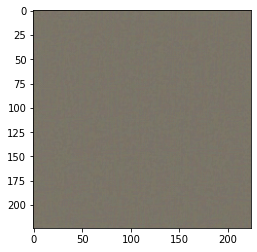

-0.5341796875


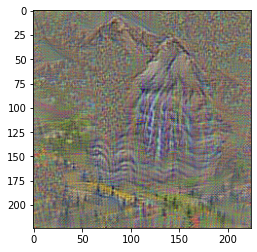

-0.5556640625


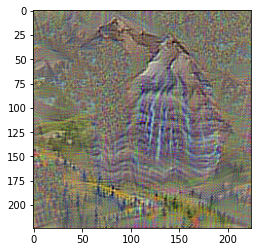

-0.5595703125


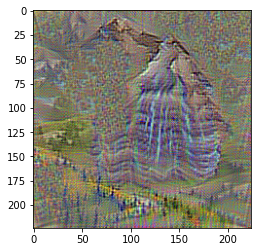

-0.57958984375


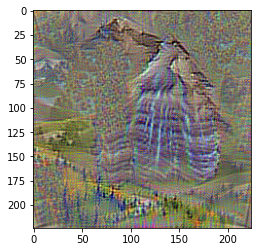

-0.5693359375


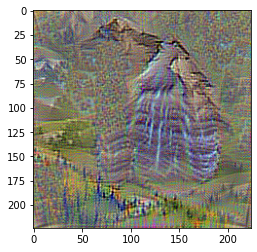

-0.57958984375


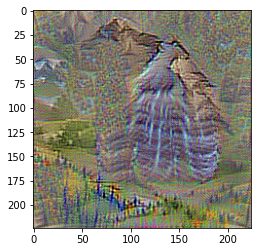

-0.57958984375


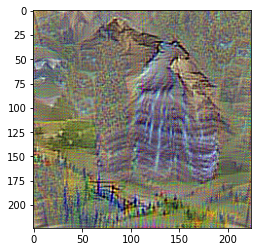

-0.58935546875


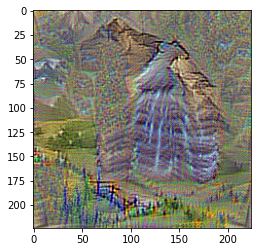

-0.59521484375


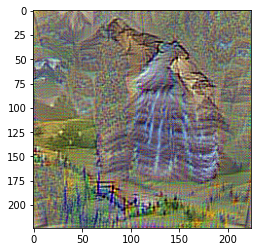

-0.57373046875


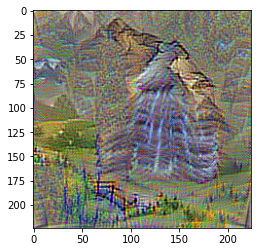

-0.6015625


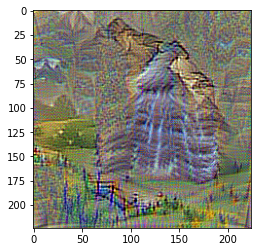

-0.59326171875


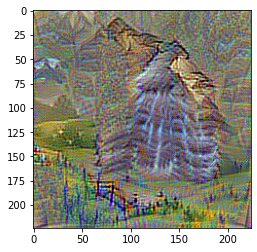

-0.60546875


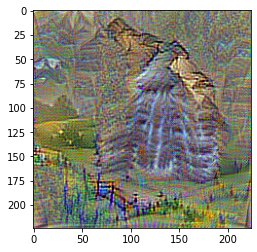

KeyboardInterrupt: 

In [28]:

text = clip.tokenize(["mountains with a waterfall"]).to(device)
text_features = model.encode_text(text)
target = text_features[0].detach()

torch.manual_seed(5)

img = 1e-2*torch.randn(1, 3, 224, 224)
img = img.to(device)
# img = img.requires_grad_()
img.requires_grad = True

opt = torch.optim.Adam([img], lr=3e-2, weight_decay=1e-6)

for i in tqdm(range(10000)):
    img_augments = augment_img(img, 4, augment='crops')
    image_features = model.encode_image(img_augments)
    
    dots = torch.cosine_similarity(image_features, target)
    loss = -dots.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%200==0:
        print(loss.item())
        imshow(img[0])
        plt.show()



# CPPN Definition

In [266]:
from torch import nn

In [267]:
def composite_activation(x):
    x = torch.tanh(x)
    # Coefficients computed by:
    #   def rms(x):
    #     return np.sqrt((x*x).mean())
    #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
    #   print(rms(a), rms(a*a))
    # print(x.shape)
    x = torch.concat([x/0.67, (x*x)/0.6], dim=1)
    # print(x.shape)
    # print()
    return x

In [268]:

# class CompositeActivation(nn.Module):
    # def forward():

class ImageCPPN(nn.Module):
    def __init__(self, n_hidden=24, n_layers=8, n_channels=3, activation=composite_activation):
        super().__init__()
        
        n_features = 2
        
        n_units = [n_features] + [n_hidden]*n_layers + [n_channels]
        n_ins = np.array(n_units[:-1])
        n_outs = np.array(n_units[1:])
        
        n_ins[1:] *= 2
        # print(n_ins, n_outs)
        self.layers = nn.ModuleList([nn.Conv2d(n_in, n_out, kernel_size=1) 
                                     for n_in, n_out in zip(n_ins, n_outs)])
        # print(self.layers)
        
        self.activation = activation
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.activation(x)
        x = self.layers[-1](x)
        x = x.sigmoid()
        return x
    
    def generate_image(self, img_size):
        a = 3.0**0.5  # std(coord_range) == 1.0
        h, w = img_size
        
        y, x = torch.linspace(-a, a, h), torch.linspace(-a, a, w)
        y, x = torch.meshgrid(y, x, indexing='ij')
        
        # r = (x.pow(2)+y.pow(2)).sqrt()
        # theta = torch.atan2(x, y)
        
        # ay, ax = y.abs(), x.abs()
        
        # plt.colorbar()
        
        
        # x = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension
        x = torch.stack([x, y], dim=0)[None]
        
        # plt.imshow(x[0, 1])
        # plt.colorbar()
        x = x.to(self.layers[0].weight.device)
        return self(x)
        
cppn = ImageCPPN()
# cppn.calc_features((100, 100))
x = cppn.generate_image((100, 100))

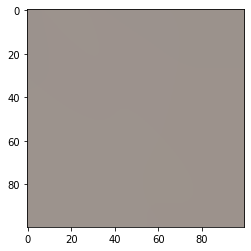

In [249]:
imshow(x[0])

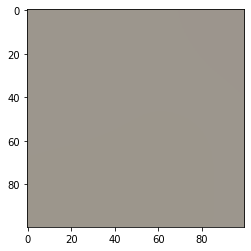

In [130]:
imshow(x[0])

# Optimizing CPPN for XOR

  0%|          | 0/100 [00:00<?, ?it/s]

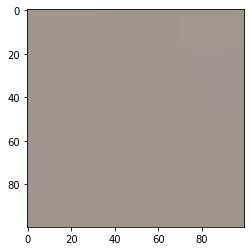

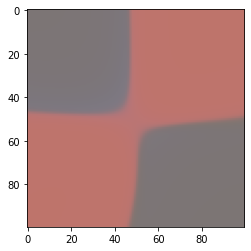

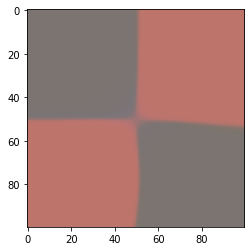

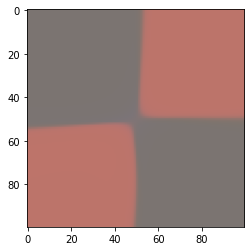

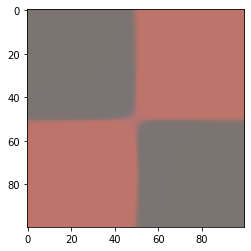

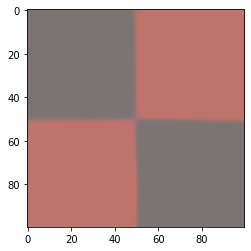

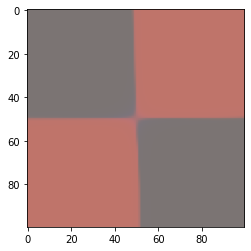

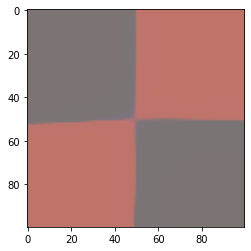

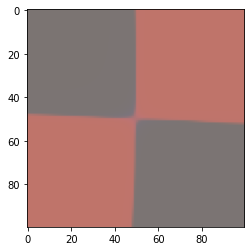

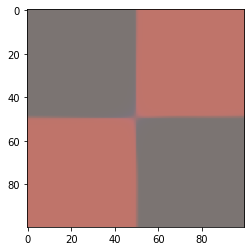

In [166]:
cppn = ImageCPPN(n_channels=3)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-2)

for i in tqdm(range(100)):
    
    x = cppn.generate_image((100, 100))[0]
    
    # loss = x[0, [1, 2], 0, 0].mean().pow(2) + x[0, [0, 2], -1, -1].mean().pow(2)
    half = x.shape[-1]//2
    loss = (x[0,:half,:half]).pow(2).mean() + (x[[0,1],half:,half:]).pow(2).mean() + (1.-x[0,half:,:half]).pow(2).mean() + (1.-x[0,:half,half:]).pow(2).mean()
    # loss = (1.-x).pow(2).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i%10==0:
        # plt.imshow(x[0].detach().cpu(), vmin=0, vmax=1)
        # plt.colorbar()
        imshow(x)
        plt.show()
    

In [150]:
cppn = ImageCPPN(n_channels=3)
np.sum([p.numel() for p in cppn.parameters()])

8451

# Optimizing CPPN to a CLIP Text

  0%|          | 0/10000 [00:00<?, ?it/s]

-0.2237548828125


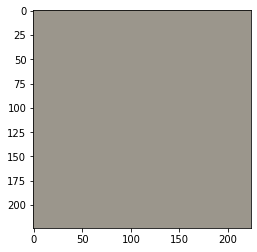

-0.323974609375


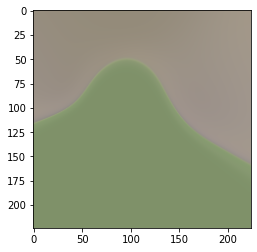

-0.35302734375


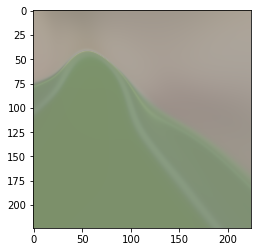

-0.394287109375


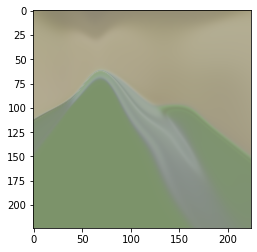

-0.39892578125


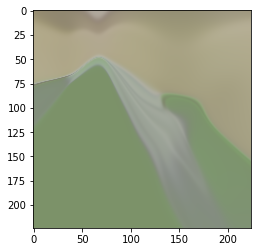

-0.40234375


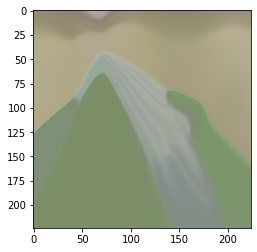

-0.411865234375


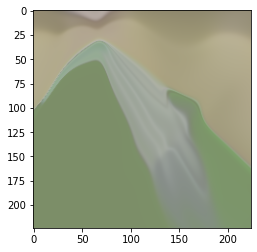

KeyboardInterrupt: 

In [269]:
text = clip.tokenize(["mountain with a waterfall"]).to(device)
text_features = model.encode_text(text)
target = text_features[0].detach()

torch.manual_seed(5)


cppn = ImageCPPN()
cppn = cppn.to(device)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-3)#, weight_decay=1e-6)

for i in tqdm(range(10000)):
    img = cppn.generate_image((224, 224))
    img_augments = augment_img(img, 4, augment='crops')
    image_features = model.encode_image(img_augments)
    
    dots = torch.cosine_similarity(image_features, target)
    loss = -dots.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%200==0:
        print(loss.item())
        imshow(img[0])
        plt.show()



# Optimizing CPPN to a target image (does not work in the slightest)
I think this is expected though...
https://silky.github.io/cppn-playground/

In [271]:
target = preprocess(Image.open("dog.png"))

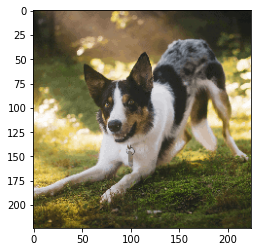

In [272]:
imshow(target)

  0%|          | 0/100 [00:00<?, ?it/s]

2.9087004804750904e-08 0.0011507272720336914 0.14713235199451447
1.820434772525914e-05 0.07434984296560287 0.6988827586174011

Loss:  1.2487068176269531


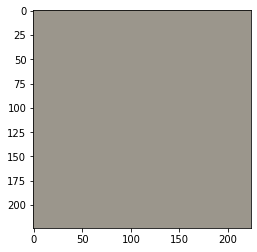

4.8260062612826005e-09 0.0012585935182869434 0.14605370163917542
5.287275598675478e-06 0.07434629648923874 0.6978828310966492

1.02063495432958e-08 0.0014287778176367283 0.14478212594985962
2.6475208869669586e-06 0.07435636222362518 0.6968886852264404

6.835773547209101e-08 0.0016685345908626914 0.1432383507490158
9.006030268210452e-06 0.07437969744205475 0.6959049105644226

1.3204839888203423e-08 0.0019858914893120527 0.1413252353668213
3.001022014359478e-05 0.07441631704568863 0.6949334740638733

2.7518085587985297e-09 0.002388626104220748 0.1389063149690628
4.7149951569736e-06 0.07446310669183731 0.6939734816551208

3.8668758861604147e-08 0.0028579540085047483 0.13581368327140808
1.941797927429434e-05 0.07451783865690231 0.694470226764679

1.0520651017031923e-07 0.0033474850933998823 0.13185764849185944
4.5406646677292883e-05 0.07458020746707916 0.6954582929611206

1.952676882410742e-07 0.0037889571394771338 0.12688864767551422
4.100693786313059e-06 0.07464979588985443 0.69644409418

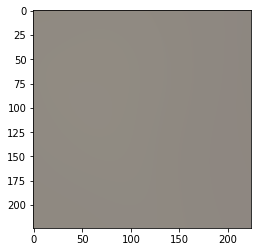

1.1912106856470928e-07 0.0038255341351032257 0.11658719927072525
1.022309334075544e-05 0.07489883899688721 0.699470579624176

2.564417513895023e-07 0.0033656267914921045 0.11619400978088379
3.2389580155722797e-06 0.07499415427446365 0.7004937529563904

1.3555734312831191e-08 0.002853606129065156 0.11282796412706375
3.167097020195797e-06 0.07509414851665497 0.7014884352684021

1.2269265425857157e-07 0.0024005898740142584 0.10726462304592133
3.492985342745669e-06 0.07519852370023727 0.7024244070053101

1.697753759799525e-08 0.0020460146479308605 0.10091130435466766
1.0599983397696633e-05 0.07530305534601212 0.7032822966575623

8.143650198633168e-09 0.0017519205575808883 0.09420820325613022
1.4735861441295128e-05 0.07540519535541534 0.7040567398071289

8.657259797928418e-09 0.0015135295689105988 0.08643252402544022
1.043516294885194e-05 0.0755048394203186 0.7047519087791443

4.3424961404525675e-09 0.0013213107595220208 0.07837837189435959
2.3367529138340615e-05 0.07560110092163086 0.70537

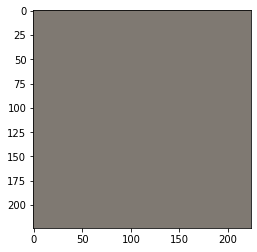

1.4783495316805784e-08 0.0008698804304003716 0.05637311562895775
0.0001102722599171102 0.07586917281150818 0.7069076895713806

2.3518844649572657e-09 0.0007564263069070876 0.050241488963365555
1.5745189330118592e-06 0.07595191150903702 0.7073280215263367

1.9651622551464243e-09 0.0006558478926308453 0.044754330068826675
3.441228045630851e-06 0.07603203505277634 0.7077117562294006

2.7383535439184925e-09 0.0005677012377418578 0.03988261520862579
1.613342647033278e-06 0.07610943168401718 0.7080625295639038

1.3117158914610627e-08 0.0004925265093334019 0.03558364883065224
1.9264207367086783e-05 0.07618359476327896 0.708383321762085

7.328225137825939e-09 0.000428445782745257 0.03180818259716034
1.4639042547059944e-06 0.07625452429056168 0.7086766362190247

1.8674981561161985e-09 0.0003733511839527637 0.028504425659775734
2.5587174604879692e-05 0.07632238417863846 0.7089447379112244

1.3461356473953856e-09 0.00032666928018443286 0.02562086284160614
1.3153069630789105e-05 0.0763870626688003

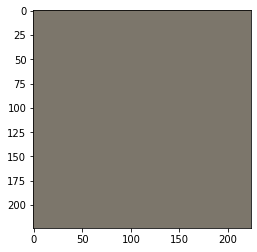

5.438032246729563e-10 0.00022645136050414294 0.019011111930012703
4.5211090764496475e-06 0.07656072825193405 0.7098034620285034

1.9610979506978765e-09 0.0002035569486906752 0.017346911132335663
2.0820903955609538e-05 0.07661278545856476 0.7099730968475342

4.404654418976861e-11 0.00018460940918885171 0.01589248515665531
8.658651495352387e-06 0.07666151225566864 0.7101277112960815

1.7708998711896129e-09 0.00016823549231048673 0.014618538320064545
1.876701617220533e-06 0.07670790702104568 0.710268497467041

2.625775152864662e-10 0.00015397256356664002 0.01349976472556591
3.524753265082836e-05 0.07675231248140335 0.7103967070579529

4.5295500683550927e-10 0.00014155493408907205 0.012514469213783741
1.3931877447248553e-06 0.0767941102385521 0.7105134129524231

1.2225598311488284e-10 0.00013078446500003338 0.011644071899354458
2.3307914034376154e-06 0.07683352380990982 0.7106195688247681

1.826774287394528e-10 0.00012128680828027427 0.010872756130993366
2.204022166552022e-05 0.07687057554

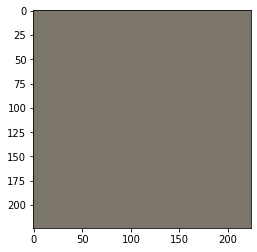

1.0231815394945443e-12 9.860659338301048e-05 0.009028048254549503
2.3981161575648002e-05 0.07696855068206787 0.7109565138816833

4.172392986667717e-11 9.255227632820606e-05 0.00853663682937622
8.766169798946066e-07 0.07699766010046005 0.7110224962234497

1.1069900551774481e-10 8.713684655958787e-05 0.008093995042145252
4.753446046379395e-05 0.07702483236789703 0.711082398891449

1.9901236214536766e-10 8.233410335378721e-05 0.007694016210734844
7.903775440354366e-06 0.07705031335353851 0.7111368179321289

7.807154922545578e-11 7.798139267833903e-05 0.007331446278840303
5.041759777668631e-06 0.07707440853118896 0.7111862301826477

1.9099055670324105e-10 7.404667121591046e-05 0.0070017664693295956
2.646917346282862e-05 0.07709735631942749 0.7112310528755188

1.2613390332205654e-09 7.046549580991268e-05 0.006701085716485977
5.681024504156085e-06 0.07711892575025558 0.7112717628479004

1.3849532631837747e-11 6.719287921441719e-05 0.006426055449992418
9.098493137571495e-06 0.0771394520998001

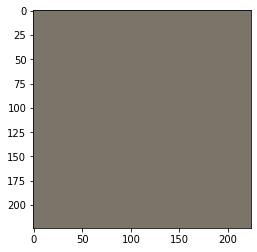

6.518321993276288e-11 5.89186092838645e-05 0.005727601237595081
2.8975311579415575e-05 0.07719410955905914 0.7113999724388123

1.0749445777946676e-10 5.658273585140705e-05 0.00552961602807045
2.0352895262476522e-06 0.07721030712127686 0.7114248871803284

1.3662582176721116e-10 5.442206020234153e-05 0.005346045363694429
2.5755052774911746e-05 0.07722562551498413 0.7114474177360535

3.240323565023573e-10 5.2419622079469264e-05 0.005175410769879818
1.955839070433285e-05 0.07724007219076157 0.7114678025245667

1.0147971352125751e-10 5.056040026829578e-05 0.005016579758375883
1.2788640560756903e-05 0.07725370675325394 0.711486279964447

8.601674927888325e-11 4.8831021558726206e-05 0.004868882708251476
4.469922259886516e-06 0.07726658880710602 0.7115029692649841

7.176481631177012e-12 4.72199717478361e-05 0.004730565939098597
1.536228751319868e-06 0.077278733253479 0.7115180492401123

3.176126028847648e-12 4.5716817112406716e-05 0.004600748419761658
2.262190491819638e-06 0.07729015499353409 

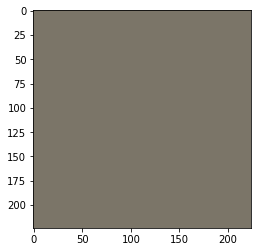

1.2683876171593056e-10 4.176544098299928e-05 0.004254940897226334
1.3446776392811444e-05 0.07732127606868744 0.7115649580955505

8.972250720162833e-11 4.0609538700664416e-05 0.004152147565037012
8.593528036726639e-06 0.07733070850372314 0.7115739583969116

2.1721291432186263e-11 3.954818384954706e-05 0.004054723773151636
2.7287887860438786e-06 0.07733967900276184 0.7115820646286011

5.240427189412422e-11 3.856406328850426e-05 0.003962222952395678
8.995446592052758e-07 0.07734830677509308 0.7115893363952637

5.880229636545664e-11 3.763317727134563e-05 0.003874249290674925
2.068248932118877e-06 0.07735653221607208 0.7115958333015442

9.706324632929864e-11 3.675074185593985e-05 0.003790447488427162
4.524838914221618e-06 0.07736437022686005 0.7116016745567322

5.451994411487249e-11 3.591264976421371e-05 0.0037104988005012274
6.5199033087992575e-06 0.07737182825803757 0.7116069197654724

3.5665914666083154e-11 3.5115583159495145e-05 0.003634111024439335
8.09848279459402e-06 0.07737894356250

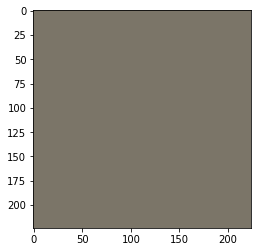

1.1575022884624531e-10 3.294025736977346e-05 0.003423843765631318
9.639001063987962e-07 0.07739867269992828 0.7116227149963379

5.488942633746774e-12 3.22785708704032e-05 0.003359335707500577
1.853423896136519e-06 0.07740481942892075 0.7116256356239319

1.2572076713013303e-10 3.164491135976277e-05 0.003297309624031186
4.255437033862108e-06 0.07741090655326843 0.7116281986236572

5.4154014605956036e-11 3.1037394364830106e-05 0.0032376062590628862
3.3694391277094837e-06 0.07741690427064896 0.7116304636001587

3.830496336787448e-11 3.0454242732957937e-05 0.003180078696459532
5.943611085967859e-06 0.07742269337177277 0.7116324305534363

1.255617831930067e-11 2.9893883038312197e-05 0.0031245886348187923
7.525605383307266e-07 0.07742832601070404 0.7116341590881348

1.765332741099357e-10 2.9354872822295874e-05 0.00307101896032691
4.282409463485237e-06 0.07743380218744278 0.7116356492042542

1.99112781817945e-10 2.8835860575782135e-05 0.0030192581471055746
8.323553629452363e-06 0.0774390995502

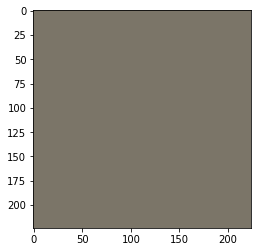

1.4543753701357076e-10 2.738701914495323e-05 0.002873829100281
1.3751686083196546e-06 0.07745416462421417 0.7116397619247437

1.111687131238881e-10 2.693675742193591e-05 0.0028283449355512857
3.7007059745519655e-06 0.077458955347538 0.7116404175758362

9.409362178303127e-12 2.6501304091652855e-05 0.0027842277195304632
2.3162137949839234e-06 0.07746361196041107 0.7116409540176392

5.691920546002649e-11 2.6079820599989034e-05 0.002741411095485091
8.601571153121768e-07 0.077468141913414 0.7116413712501526

2.7118751688703924e-11 2.5671537514426745e-05 0.0026998291723430157
6.591432679670106e-07 0.07747256755828857 0.7116416692733765

1.5051224155904208e-11 2.5275765437982045e-05 0.0026594249065965414
2.2341716885421192e-06 0.07747688889503479 0.7116418480873108

3.2024105589556484e-12 2.4891854991437867e-05 0.0026201389264315367
3.858144282276044e-06 0.07748110592365265 0.7116419672966003

2.049878322640808e-11 2.4519213184248656e-05 0.002581924432888627
5.524939297174569e-06 0.0774852409

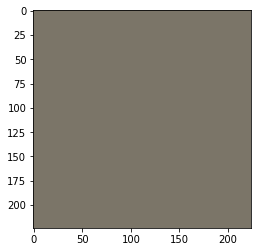

7.10943803827746e-11 2.3463648176402785e-05 0.002473234198987484
7.18643786967732e-06 0.07749729603528976 0.7116418480873108

8.412559537873676e-11 2.3130922272684984e-05 0.0024388490710407495
6.168354957480915e-06 0.07750120013952255 0.7116416692733765

4.260414243617561e-11 2.2807042114436626e-05 0.002405323786661029
5.092393621453084e-06 0.07750502973794937 0.7116414308547974

7.606565377571428e-11 2.2491609342978336e-05 0.002372622024267912
3.964179541071644e-06 0.07750878483057022 0.7116411328315735

7.686185021782421e-12 2.2184249246492982e-05 0.0023407135158777237
2.788823621813208e-06 0.0775124803185463 0.7116408348083496

2.447020364115815e-11 2.1884634406887926e-05 0.0023095670621842146
1.5709687204434886e-06 0.07751614600419998 0.711640477180481

7.555453485075247e-11 2.1592419216176495e-05 0.0022791519295424223
3.1483207862947893e-07 0.07751975953578949 0.7116401195526123

7.785691535922012e-11 2.130732173100114e-05 0.002249443205073476
9.757550287758932e-07 0.0775233134627

In [273]:
torch.manual_seed(5)

cppn = ImageCPPN()
cppn = cppn.to(device)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-3)#, weight_decay=1e-6)

for i in tqdm(range(100)):
    img = cppn.generate_image((224, 224))
    loss = (img-target.to(img)).pow(2).mean()
    
    opt.zero_grad()
    loss.backward()
    a = torch.cat([p.grad.flatten() for p in cppn.parameters()]).detach()
    b = torch.cat([p.flatten() for p in cppn.parameters()]).detach()
    opt.step()
    print(a.abs().min().item(), a.abs().mean().item(), a.abs().max().item())
    print(b.abs().min().item(), b.abs().mean().item(), b.abs().max().item())
    print()

    if i%10==0:
        print("Loss: ", loss.item())
        imshow(img[0])
        plt.show()
